In [2]:
import json
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")
from plotting_parameters import *

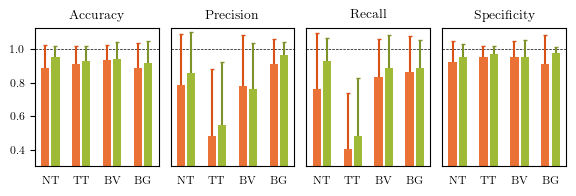

In [44]:
def load_metrics(file):
    metrics = []
    with open(file, 'r') as f:
        results = json.load(f)
        metrics.append(results['accuracy'])
        metrics.append(results['precision'])
        metrics.append(results['recall'])
        metrics.append(results['specificity'])
        metrics.append(results['f1_score'])
        # check if 'roc_auc' is in the results
        if 'roc_auc' in results:
            metrics.append(results['roc_auc'])
        if 'label_counts' in results:
            return metrics, results['label_counts']
    return metrics

def fold_mean_metrics(results_dir):
    metrics = []
    for i, file in enumerate(['fold1_metrics.json', 'fold2_metrics.json', 'fold3_metrics.json', 'fold4_metrics.json', 'fold5_metrics.json']):     
        metrics.append(load_metrics(os.path.join(results_dir, file)))
    metrics_mean = np.mean(metrics, axis=0)
    metrics_std = np.std(metrics, axis=0)
    return metrics_mean, metrics_std


def knn_metrics(folder):
    # iterate through all files in the folder
    metrics = []
    for file in os.listdir(folder):
        if file.endswith('.json'):
            img_metrics, img_label_count = load_metrics(os.path.join(folder, file))
            # set metrics to nan if class is not present in the image
            for i, count in enumerate(img_label_count):
                if count == 0:
                    for metric in img_metrics:
                        metric[i] = np.nan
            metrics.append(img_metrics)
    metrics_mean = np.nanmean(metrics, axis=0)
    metrics_std = np.nanstd(metrics, axis=0)
    return metrics_mean, metrics_std
            
# scores_bl, stds_bl = fold_mean_metrics('./models5/baseline/v1/results')
# scores_hm, stds_hm = fold_mean_metrics('./models5/heatmaps/v1/results')

scores_bl, stds_bl = knn_metrics('./models5/baseline/v1/results/knn_metrics')
scores_hm, stds_hm = knn_metrics('./models5/heatmaps/v1/results/knn_metrics')

set_plotting_style("latex")
fig, axs = plt.subplots(1,4, figsize=(5.8,2))
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity']# 'F1 Score']#, 'ROC AUC']
for i, metric, score_bl, score_hm, std_bl, std_hm in zip(range(4), metrics, scores_bl, scores_hm, stds_bl, stds_hm):
    axs[i].axhline(y=1, color='black', linestyle='--', linewidth=0.5, zorder=1)
    axs[i].errorbar(range(0,12,3), score_bl, yerr=std_bl, fmt='none', ecolor=tum_red_dark, capsize=1.5, zorder=1)
    axs[i].bar(range(0,12,3), score_bl, color=tum_red, label='Baseline all data', zorder=2)
    axs[i].errorbar(range(1,12,3), score_hm, yerr=std_hm, fmt='none', ecolor=tum_green_dark, capsize=1.5, zorder=1)
    axs[i].bar(range(1,12,3), score_hm, color=tum_green, label='Heatmaps all data', zorder=2)
    axs[i].set_xticks([0.5, 3.5, 6.5, 9.5])
    axs[i].set_xticklabels(['NT', 'TT', 'BV', 'BG'])
    axs[i].set_title(metric)
    axs[i].set_yticks([])
    axs[i].set_ylim(0.3,1.13)
    axs[i].set_xlim(-1, 11)
    #add dashed line at y=1
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False,
               left=False, right=False, labelbottom=True, labelleft=True)
axs[0].set_yticks([0.4, 0.6, 0.8, 1])
# save figure as svg
plt.tight_layout()
plt.savefig('results.svg')

import csv
with open('results.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Class', 'NT','NT', 'TT','TT', 'BV','BV', 'BG','BG'])
    writer.writerow(['model', 'BL', 'HM', 'BL', 'HM', 'BL', 'HM', 'BL', 'HM'])
    for metric, score_bl, score_hm in zip(['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 score', 'AUC ROC'], scores_bl, scores_hm):
        writer.writerow([metric, score_bl[0], score_hm[0], score_bl[1], score_hm[1], score_bl[2], score_hm[2], score_bl[3], score_hm[3]])

In [ ]:
# def load_results(file, auc=True, label_counts=False):
#     metrics = []
#     with open(file, 'r') as f:
#         results = json.load(f)
#         accuracy = results['accuracy']
#         precision = results['precision']
#         recall = results['recall']
#         f1_score = results['f1_score']
#         specificity = results['specificity']
#         if auc:
#             roc_auc = results['roc_auc']
#             return accuracy, precision, recall, specificity, f1_score, roc_auc
#         if label_counts:
#             return accuracy, precision, recall, specificity, f1_score, results['label_counts']
#     return accuracy, precision, recall, specificity, f1_score

def get_fold_mean(results_dir):
    accuracy_all = []
    precision_all = []  
    recall_all = []
    f1_score_all = []
    roc_auc_all = []
    specificity_all = []
    for i, file in enumerate(['fold1_metrics.json', 'fold2_metrics.json', 'fold3_metrics.json', 'fold4_metrics.json', 'fold5_metrics.json']):     
        accuracy, precision, recall, specificity, f1_score, roc_auc  = load_results(os.path.join(results_dir, file))
        accuracy_all.append(accuracy)
        precision_all.append(precision)
        recall_all.append(recall)
        f1_score_all.append(f1_score)
        roc_auc_all.append(roc_auc)
        specificity_all.append(specificity)
    accuracy_all = np.mean(accuracy_all, axis=0)
    precision_all = np.mean(precision_all, axis=0)
    recall_all = np.mean(recall_all, axis=0)
    f1_score_all = np.mean(f1_score_all, axis=0)
    roc_auc_all = np.mean(roc_auc_all, axis=0)
    specificity_all = np.mean(specificity_all, axis=0)
    return [accuracy_all, precision_all, recall_all, specificity_all, f1_score_all, roc_auc_all]


def get_fold_metrics(results_dir):
    metrics = []
    for i, file in enumerate(['fold1_metrics.json', 'fold2_metrics.json', 'fold3_metrics.json', 'fold4_metrics.json', 'fold5_metrics.json']):     
        metrics.append(load_results(os.path.join(results_dir, file)))
    metrics_mean = np.mean(metrics, axis=0)
    metrics_std = np.std(metrics, axis=0)
    return metrics_mean, metrics_std

def get_fold_std(results_dir):
    accuracy_all = []
    precision_all = []
    recall_all = []
    f1_score_all = []
    roc_auc_all = []
    specificity_all = []
    for i, file in enumerate(['fold1_metrics.json', 'fold2_metrics.json', 'fold3_metrics.json', 'fold4_metrics.json', 'fold5_metrics.json']):     
        accuracy, precision, recall, specificity, f1_score, roc_auc  = load_results(os.path.join(results_dir, file))
        accuracy_all.append(accuracy)
        precision_all.append(precision)
        recall_all.append(recall)
        f1_score_all.append(f1_score)
        roc_auc_all.append(roc_auc)
        specificity_all.append(specificity)
    accuracy_all = np.std(accuracy_all, axis=0)
    precision_all = np.std(precision_all, axis=0)
    recall_all = np.std(recall_all, axis=0)
    f1_score_all = np.std(f1_score_all, axis=0)
    roc_auc_all = np.std(roc_auc_all, axis=0)
    specificity_all = np.std(specificity_all, axis=0)
    return [accuracy_all, precision_all, recall_all, specificity_all, f1_score_all, roc_auc_all]


# scores_bl_1 = get_fold_mean('./models5/baseline/v1/results')
# stds_bl_1 = get_fold_std('./models5/baseline/v1/results')
# scores_bl_2 = get_fold_mean('./models5/baseline/v1_2/results')
# stds_bl_2 = get_fold_std('./models5/baseline/v1_2/results')
# scores_bl_3 = get_fold_mean('./models5/baseline/v1_3/results')
# stds_bl_3 = get_fold_std('./models5/baseline/v1_3/results')
# scores_bl_4 = get_fold_mean('./models5/baseline/v1_4/results')
# stds_bl_4 = get_fold_std('./models5/baseline/v1_4/results')

# scores_hm_1 = get_fold_mean('./models5/heatmaps/v1/results')
# stds_hm_1 = get_fold_std('./models5/heatmaps/v1/results')
# scores_hm_2 = get_fold_mean('./models5/heatmaps/v1_2/results')
# stds_hm_2 = get_fold_std('./models5/heatmaps/v1_2/results')
# scores_hm_3 = get_fold_mean('./models5/heatmaps/v1_3/results')
# stds_hm_3 = get_fold_std('./models5/heatmaps/v1_3/results')
# scores_hm_4 = get_fold_mean('./models5/heatmaps/v1_4/results')
# stds_hm_4 = get_fold_std('./models5/heatmaps/v1_4/results')

# scores_bl = np.mean([scores_bl_1, scores_bl_2, scores_bl_3, scores_bl_4], axis=0)
# stds_bl = np.mean([stds_bl_1, stds_bl_2, stds_bl_3, stds_bl_4], axis=0)
# scores_hm = np.mean([scores_hm_1, scores_hm_2, scores_hm_3, scores_hm_4], axis=0)
# stds_hm = np.mean([stds_hm_1, stds_hm_2, stds_hm_3, stds_hm_4], axis=0)

In [41]:
import lightning.pytorch as pl
from model import ClassificationModel

# model_path = 'logs4/bl/my_model/version_42/checkpoints/epoch=27-step=454636.ckpt'
# model = ClassificationModel.load_from_checkpoint(model_path)
# print(model.hparams)
# model_path = 'logs4/bl/my_model/version_23/checkpoints/epoch=28-step=470873.ckpt'
# model = ClassificationModel.load_from_checkpoint(model_path)
# print(model.hparams)
# model_path = 'logs4/bl/my_model/version_8/checkpoints/epoch=21-step=357214.ckpt'
# model = ClassificationModel.load_from_checkpoint(model_path)
# print(model.hparams)

# model_path = 'logs4/hm/my_model/version_45/checkpoints/epoch=6-step=56826.ckpt'
# model = ClassificationModel.load_from_checkpoint(model_path)
# print(model.hparams)
# model_path = 'logs4/hm/my_model/version_22/checkpoints/epoch=11-step=194844.ckpt'
# model = ClassificationModel.load_from_checkpoint(model_path)
# print(model.hparams)
# model_path = 'logs4/hm/my_model/version_35/checkpoints/epoch=11-step=194844.ckpt'
# model = ClassificationModel.load_from_checkpoint(model_path)
# print(model.hparams)

model_path = 'logs4/hm_only/my_model/version_8/checkpoints/epoch=36-step=554260.ckpt'
model = ClassificationModel.load_from_checkpoint(model_path)
print(model.hparams)

"config":      {'hidden_dim': 4, 'num_layers': 0, 'last_layer_dim': 4, 'lr': 1.6756813861488494e-05, 'weight_decay': 0.0029548945587266834, 'num_epochs': 100, 'log_dir': './logs4/hm_only', 'batch_size': 32}
"input_dim":   66
"loss_weight": tensor([8.0522e-06, 4.5239e-05, 1.9842e-05, 3.5374e-06], device='cuda:0')
"output_dim":  4
